# Import Required Libraries
Import the necessary libraries, including PyTorch, NumPy, and Matplotlib.

In [114]:
# Importing the necessary libraries
from fastai.basics import DataLoaders, Learner, accuracy, Adam
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define Inception Module
Define the inception module, which is the building block of the InceptionTime architecture.

In [46]:
class InceptionModule(nn.Module):
    """
    InceptionModule is a module that implements the Inception module architecture.
    
    Args:
        in_channels (int): Number of input channels.
        n_filters (int): Number of filters for each convolutional layer.
        kernel_sizes (list): List of kernel sizes for the convolutional layers.
        bottleneck_channels (int): Number of channels in the bottleneck layer.
    """
    def __init__(self, in_channels, n_filters, kernel_sizes, bottleneck_channels):
        super(InceptionModule, self).__init__()
        self.bottleneck = nn.Conv1d(in_channels, bottleneck_channels, 
                                    kernel_size=1, bias=False)
        
        self.convs = nn.ModuleList()
        for kernel_size in kernel_sizes:
            self.convs.append(nn.Conv1d(bottleneck_channels, n_filters, 
                                        kernel_size, padding='same', bias=False))
        
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=1, padding=1)
        self.maxpool_conv = nn.Conv1d(bottleneck_channels, n_filters, 
                                      kernel_size=1, bias=False)
        
        self.batchnorm = nn.BatchNorm1d(n_filters * (len(kernel_sizes) + 1))
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.bottleneck(x)
    
        conv_outputs = [conv(x) for conv in self.convs]
        maxpool_output = self.maxpool(x)
        maxpool_output = self.maxpool_conv(maxpool_output)
        
        outputs = torch.cat(conv_outputs + [maxpool_output], 1)
        outputs = self.batchnorm(outputs)
        return self.relu(outputs)


In [47]:
# Test
n_samples = 10
n_channels = 3
n_timepoints = 100
x = torch.randn(n_samples, n_channels, n_timepoints)
inception = InceptionModule(n_channels, 32, [10, 20, 40], 32)
print(inception(x).shape)

torch.Size([10, 128, 100])


# Define InceptionTime Architecture
Define the InceptionTime architecture by stacking multiple inception modules.

In [62]:
class InceptionTime(nn.Module):
    def __init__(self, n_classes, in_channels, kszs=[10, 20, 40]):
        super(InceptionTime, self).__init__()
        self.inception_block1 = InceptionModule(in_channels, n_filters=32, 
                                                kernel_sizes=kszs, 
                                                bottleneck_channels=32)
        # The output channels are the number of filters times the number of paths (3 convs + 1 maxpool)
        out_channels = 32 * (len(kszs) + 1)
        
        # Subsequent Inception modules have out_channels as their in_channels
        self.inception_block2 = InceptionModule(out_channels, n_filters=32, 
                                                kernel_sizes=kszs, 
                                                bottleneck_channels=32)
        self.inception_block3 = InceptionModule(out_channels, n_filters=32, 
                                                kernel_sizes=kszs, 
                                                bottleneck_channels=32)
        self.inception_block4 = InceptionModule(out_channels, n_filters=32, 
                                                kernel_sizes=kszs, 
                                                bottleneck_channels=32)
        self.inception_block5 = InceptionModule(out_channels, n_filters=32, 
                                                kernel_sizes=kszs, 
                                                bottleneck_channels=32)
        self.inception_block6 = InceptionModule(out_channels, n_filters=32, 
                                                kernel_sizes=kszs, 
                                                bottleneck_channels=32)
        
        self.residual_conv = nn.Conv1d(in_channels, out_channels, 
                                       kernel_size=1, stride=1, bias=False)
        self.bn = nn.BatchNorm1d(out_channels)
        self.act = nn.ReLU()
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(out_channels, n_classes)

    def forward(self, x):
        res = x # Save residual
        # Apply blocks
        for i, inception_block in enumerate([self.inception_block1,
                                             self.inception_block2, 
                                             self.inception_block3, 
                                             self.inception_block4, 
                                             self.inception_block5,
                                             self.inception_block6]):
            # Residuals after block 3 nd block 6
            x = inception_block(x)
            if (i == 2):
                x += self.act(self.bn(self.residual_conv(res)))
                res = x
            if (i == 5):
                x += self.act(self.bn(res))
        
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [65]:
# Test
n_samples = 10
n_channels = 3
n_timepoints = 100
x = torch.randn(n_samples, n_channels, n_timepoints)
num_classes = 2  # Assuming we have 2 classes for our tsc task
model = InceptionTime(n_classes=2, in_channels=n_channels)

print(model(x).shape)

torch.Size([10, 2])


# Prepare Dataset
Load and preprocess the time series dataset for training the InceptionTime model.

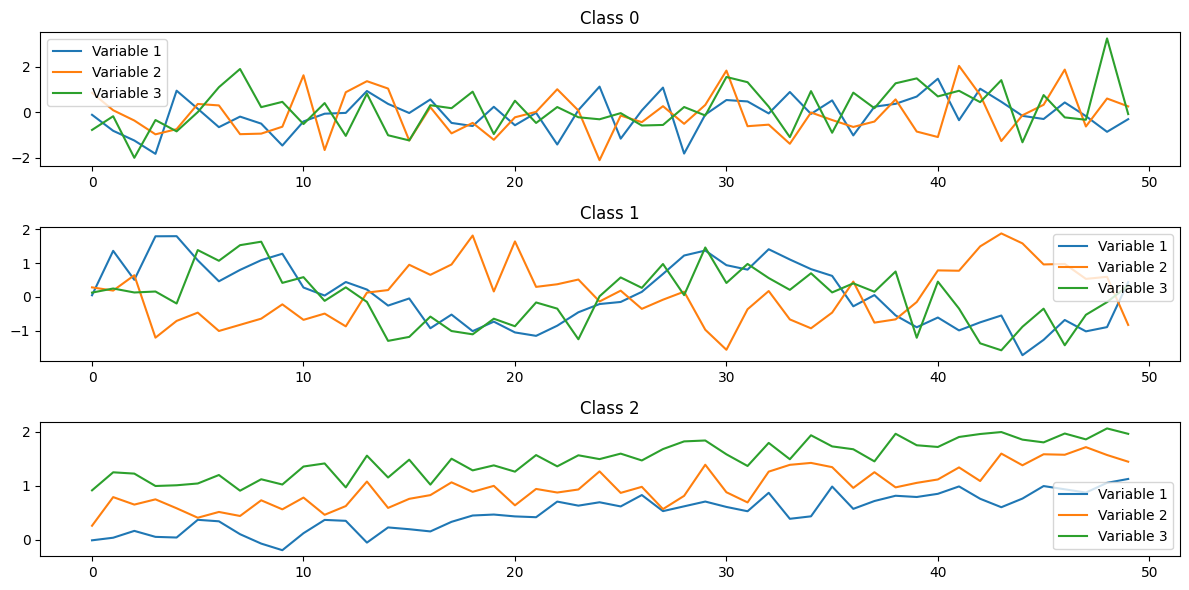

In [110]:
n_samples_per_class = 10
timesteps = 50
n_variables = 3  # Number of variables in the multivariate time series

# Class 1: Multivariate normal distribution
class_1 = np.random.normal(loc=0, scale=1, size=(n_samples_per_class, timesteps, n_variables))

# Class 2: Multivariate sinusoidal pattern with noise
time = np.linspace(0, 4*np.pi, timesteps)
class_2 = np.array([
    np.array([
        np.sin(time + phase) + np.random.normal(scale=0.5, size=timesteps) for phase in np.linspace(0, 2*np.pi, n_variables)
    ]).T for _ in range(n_samples_per_class)
])

# Class 3: Multivariate linear trend with noise
class_3 = np.array([
    np.array([
        np.linspace(i + offset, i + 1 + offset, timesteps) + np.random.normal(scale=0.2, size=timesteps) for offset in np.linspace(0, 1, n_variables)
    ]).T for i in range(n_samples_per_class)
])

# Ensure all arrays have the correct shape for concatenation
assert class_1.shape == class_2.shape == class_3.shape, "All input arrays must have the same shape for concatenation"

# Combine classes and labels
data = np.concatenate([class_1, class_2, class_3], axis=0)
labels = np.concatenate([np.zeros(n_samples_per_class), 
                         np.ones(n_samples_per_class), 
                         np.full(n_samples_per_class, 2)], axis=0).astype(int)

# Transpose data to have the correct shape (n_samples, n_variables, n_timesteps)
data = np.transpose(data, (0, 2, 1))

X_train, X_valid, y_train, y_valid = train_test_split(data, labels, test_size=0.2, random_state=42)

# Visualization
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(3, 1, i+1)
    for j in range(n_variables):
        plt.plot(data[labels == i][0, j, :], label=f'Variable {j+1}')
    plt.title(f'Class {i}')
    plt.legend()
plt.tight_layout()
plt.show()

In [112]:
# Load the dataset
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Reshape the data to fit the model input (batch, channels, timesteps)
#X = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

# Create the datasets
train_dataset = TimeSeriesDataset(X_train, y_train)
valid_dataset = TimeSeriesDataset(X_valid, y_valid)

# f-print the shape of the datasets
print(f"Train dataset shape: {X_train.shape}, {y_train.shape}")
print(f"Validation dataset shape: {X_valid.shape}, {y_valid.shape}")

Train dataset shape: torch.Size([24, 3, 50]), torch.Size([24])
Validation dataset shape: torch.Size([6, 3, 50]), torch.Size([6])


# Train InceptionTime Model
Train the InceptionTime model using the prepared dataset and visualize the training process.

In [113]:
dls = DataLoaders.from_dsets(train_dataset, valid_dataset, bs = 8)
dls.one_batch()

(tensor([[[ 0.1747,  0.1612,  0.7596,  ...,  0.1387, -0.1257,  1.2807],
          [-0.2779,  0.3270, -0.0918,  ...,  0.2751,  0.4575,  0.3761],
          [ 0.0277,  1.0385,  0.3544,  ..., -0.2248,  0.3468, -0.1823]],
 
         [[-0.1574,  0.9464, -0.0560,  ...,  0.0694,  0.4251,  0.3690],
          [ 0.0833, -0.5272, -0.2934,  ...,  0.7618, -0.0246,  0.3745],
          [ 0.4235,  0.7917,  0.1726,  ..., -1.2899, -0.1256,  0.3081]],
 
         [[-0.0485, -0.2636,  0.9881,  ..., -0.5183,  0.2826, -0.2124],
          [-0.3948, -0.5241, -0.6823,  ...,  0.0218,  0.0423,  0.6619],
          [ 0.6304,  0.0800,  0.7329,  ..., -0.5007,  0.2313, -0.3253]],
 
         ...,
 
         [[ 0.1381,  0.5978, -0.5743,  ..., -0.1240,  0.0567, -0.8056],
          [-0.9078,  0.1891, -0.0512,  ..., -0.3205,  0.7060,  0.4128],
          [ 0.5448,  0.1230,  0.1597,  ..., -0.1373, -0.0834,  0.7050]],
 
         [[ 6.2266,  5.9667,  5.7519,  ...,  6.9187,  6.6613,  7.1841],
          [ 6.5194,  6.5666,  6.4416

In [116]:
# Move the model (and data) to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = InceptionTime(n_classes = 3, in_channels = n_variables)
model = model.to(device)

learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), opt_func=Adam, metrics=accuracy)
learn.fit(10, 1e-3)

/home/victor/.local/lib/python3.10/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [8, 128, 50]], which is output 0 of ReluBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [101]:
# Define the training function
def train_model(model, criterion, optimizer, dataloader, device, num_epochs=25):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    return model

In [86]:
# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Train the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = InceptionTime(n_classes = 3, in_channels = n_variables)
model = train_model(model, criterion, optimizer, train_loader, device, num_epochs=25)

# Plot the training loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs. Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs. Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 0/24
----------


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [8, 128, 50]], which is output 0 of ReluBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

# Evaluate Model Performance
Evaluate the performance of the trained InceptionTime model on the test dataset.

In [ ]:
# Evaluate Model Performance
from sklearn.metrics import classification_report, confusion_matrix

# Assuming we have a separate test loader
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()  # Set the model to evaluation mode
y_true = []
y_pred = []

with torch.no_grad():  # Do not calculate gradients to speed up computation
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Print the classification report
print(classification_report(y_true, y_pred))

# Print the confusion matrix
print(confusion_matrix(y_true, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix(y_true, y_pred), interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes), rotation=45)
plt.yticks(tick_marks, range(num_classes))
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Visualize Model Training
Visualize the training process of the InceptionTime model using Matplotlib.

In [ ]:
# Define the training function with loss and accuracy history
def train_model(model, criterion, optimizer, dataloader, num_epochs=25):
    loss_history = []
    accuracy_history = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        
        # Store loss and accuracy history
        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_acc)

    return model, loss_history, accuracy_history

# Train the model
model, train_loss, train_acc = train_model(model, criterion, optimizer, train_loader, num_epochs=25)

# Plot the training loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs. Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs. Epochs')
plt.legend()

plt.tight_layout()
plt.show()